# Pix2Pix

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

**Nate - Additional Notes:**

This notebook is an edited version of the Tensorflow 2.X Pix2Pix sample. It's designed to load a formatted dataset from Google Drive, train a new model, and save a Keras model back to Google Drive in the ".h5" model format.

Most of the original notes and model diagrams have been removed from the notebook so the model can be re-executed faster after re-connecting to Colab. See the original notebook for better documentation. 

The only changes (so far) are in the image loader code, and the model saving. This notebook still saves checkpoints.

In [ ]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display
import numpy as np

In [ ]:
PATH = '../dataset/Augmented/Combined/'
# Nono's data:
# PATH = '/content/drive/My Drive/DigitalFutures Workshop/Dataset/edges2daisies/'

BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  # 'w' should be 256:
  w = w // 2

  # Reversing to match our image formatting:
  input_image = image[:, :w, :]
  real_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

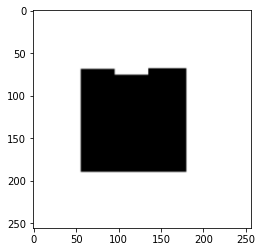

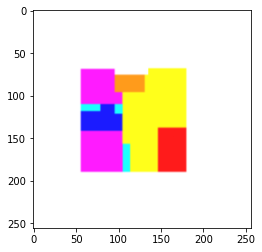

In [ ]:
# /content/drive/My Drive/DigitalFutures Workshop/Dataset/edges2daisies/Val/1031799732_e7f4008c03.png
inp, re = load(PATH+'/Train/0b439221a43d.png')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

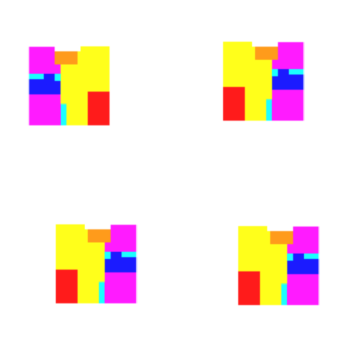

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_re/255.0)
  plt.axis('off')
  # print(rj_inp)
plt.show()

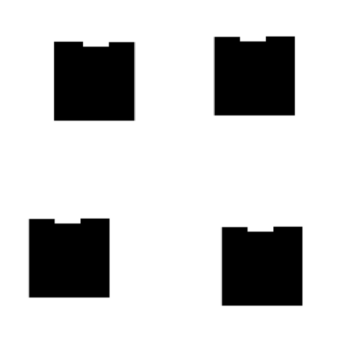

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)

  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Input Pipeline

In [ ]:
train_dataset = tf.data.Dataset.list_files(PATH+'Train/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(PATH+'Test/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
for example_input, example_target in test_dataset.take(1):
  print(np.asarray(example_input))


[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]]


## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
# @tf.function()
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [ ]:
# @tf.function()
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [ ]:
# @tf.function()
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
generator = Generator()
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


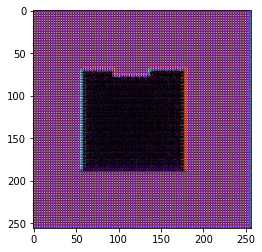

In [ ]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

The training procedure for the generator is shown below:

In [ ]:
LAMBDA = 100

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

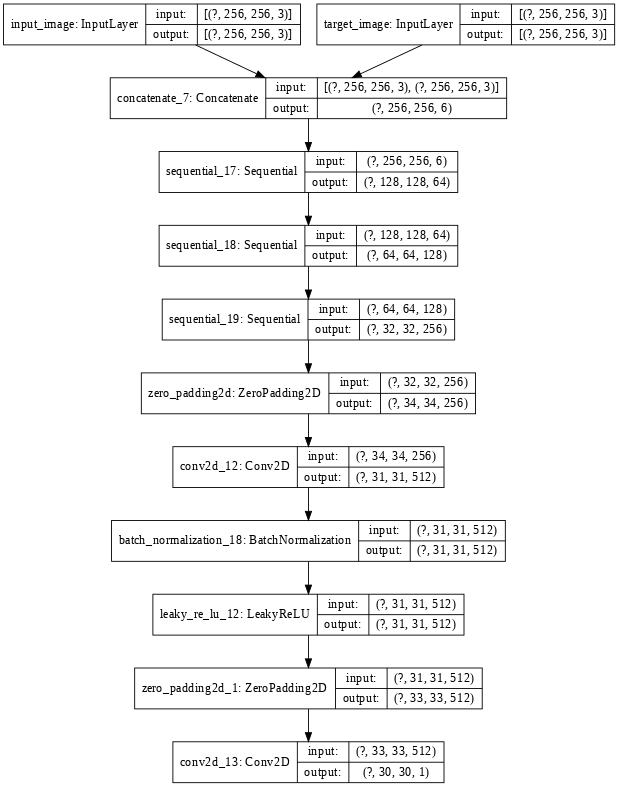

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

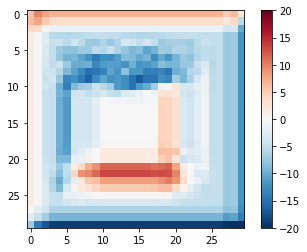

In [ ]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Define the Optimizers and Checkpoint-saver


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate Images

Write a function to plot some images during training.

* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**

Note: The `training=True` is intentional here since
we want the batch statistics while running the model
on the test dataset. If we use training=False, we will get
the accumulated statistics learned from the training dataset
(which we don't want)

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

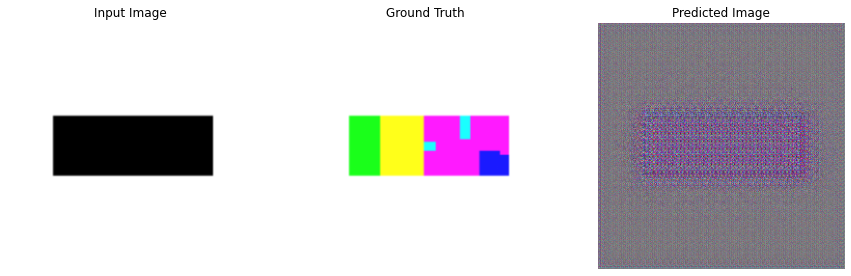

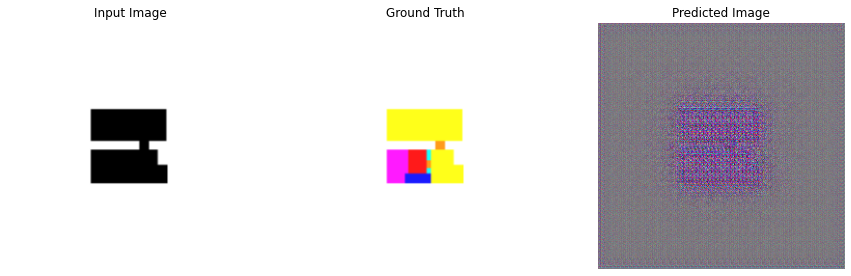

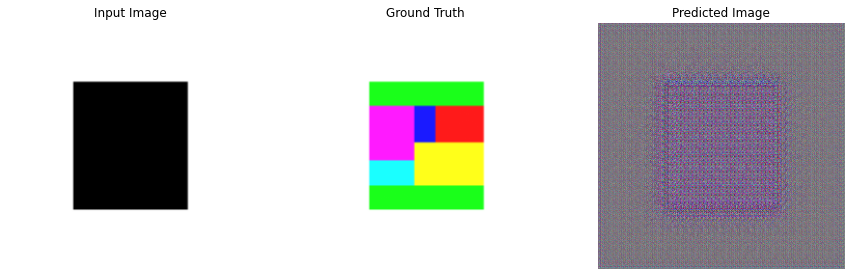

In [ ]:
for example_input, example_target in test_dataset.take(3):
  generate_images(generator, example_input, example_target)

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [ ]:
EPOCHS = 200

import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

The actual training loop:

* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.

In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    # if (epoch + 1) % 20 == 0:
    #  checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)
  # New save method for h5 format:
  # Uncomment for training in Colab instances:
  h5_dir = '../Pix2Pix Trained Models/'
  # h5_name = 'generator_model_001_edges2daisies_061720.h5'
  # h5_name = 'generator_model_002_epochs_200.h5'
  # savedmodelname = 'savedmodel'
  savedmodelname = 'savedmodel2'
  # generator.save(h5_dir+h5_name)
  generator.save(h5_dir+savedmodelname)


Now run the training loop:

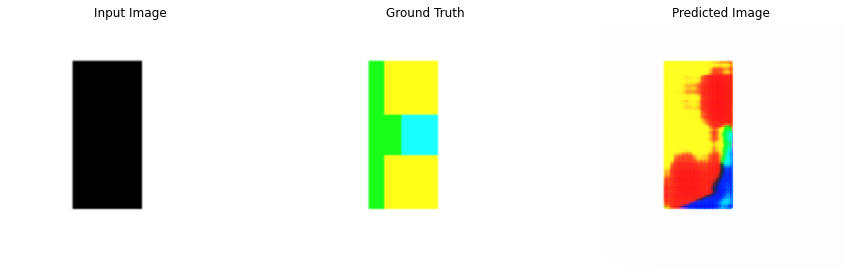

Epoch:  12
................................

KeyboardInterrupt: ignored

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

In [ ]:
# # Save the model back to Google Drive:
# generator.save('/content/drive/My Drive/generator_model_002_epochs_200.h5')

In [ ]:
  # h5_dir = '/content/drive/My Drive/pix2pix/Pix2Pix Trained Models/'
  # h5_name = 'generator_model_003_061620.h5'
  # generator.save(h5_dir+h5_name)

## Restore the latest checkpoint and test

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate using test dataset

In [ ]:
# Run the trained model on a few examples from the test dataset
# for inp, tar in test_dataset.take(5):
#   generate_images(generator, inp, tar)

In [ ]:
# # Recreate the exact same model, including its weights and the optimizer
# new_model = tf.keras.models.load_model('/content/drive/My Drive/pix2pix/Pix2Pix Trained Models/generator_model_002_epochs_200.h5')

# SavedModelVersion
# new_model = tf.keras.models.load_model('/content/drive/My Drive/pix2pix/Pix2Pix Trained Models/savedmodel')
new_model = tf.keras.models.load_model('../Pix2Pix Trained Models/savedmodel2')

In [ ]:
for inp, tar in test_dataset.take(5):
  generate_images(new_model, inp, tar)

New code: 
- Find a way to save an .h5 file and load it in the model that is configured in the Runway model_template boilerplate

In [ ]:
# # This works! :
# generator.save('generator_model_002_epochs=200.h5')

In [ ]:
# # Recreate the exact same model, including its weights and the optimizer
# new_model = tf.keras.models.load_model('/content/drive/My Drive/generator_model_002_epochs_200.h5')

# # Show the model architecture
# new_model.summary()

In [ ]:
# tf.keras.models.save_model(generator, '/content/drive/My Drive/pix2pix Colab Training', overwrite=True, include_optimizer=True)

In [ ]:
# MODEL_PATH = '/content/drive/My Drive/pix2pix Colab Training/'
# reconstructed_model = tf.keras.models.load_model('/content/drive/My Drive/pix2pix Colab Training/')

In [ ]:
# generator.compile(optimizer=generator_optimizer)